In [1]:
import numpy as np
import scipy.stats as sts
import scipy.stats as sps
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
import scipy.integrate as spint
import scipy.interpolate as spinterp

<h1>Set Up</h1>
Loading the star data, grouping them by cluster names. <br>
<i>Code provided in the assignment 1 handout.</i>

In [2]:
dr3stars = fits.open('../Data/gaiadr3_cluster_stars.fits')
dr3stars.info()
stars = pd.DataFrame(dr3stars[1].data)

Filename: ../Data/gaiadr3_cluster_stars.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      93   ()      
  1  members.dat    1 TableHDU       331   1291929R x 56C   [A20, I4, I19, I1, F10.8, F12.8, F10.8, F12.8, F10.8, F12.8, E11.4, E11.4, F10.8, E11.4, F10.8, E11.4, F10.8, F11.8, F11.8, E11.4, E11.4, E11.4, E11.4, E11.4, E11.4, I2, F12.8, F10.7, F11.8, F10.8, F19.8, F16.8, F18.8, F17.8, F18.8, F17.8, F10.7, F10.7, F10.7, E11.4, E11.4, E11.4, E9.3, F12.8, F4.1, F6.1, F5.1, F11.7, F11.8, F6.1, F12.7, F13.8, F5.1, A13, I1, I1]   


In [3]:
stars['Name'] = stars['Name'].str.strip()
clcounts = stars.groupby(['Name']).size().reset_index(name='count')

In [4]:
stars.columns

Index(['Name', 'ID', 'GaiaDR3', 'inrt', 'Prob', 'RAdeg', 'e_RAdeg', 'DEdeg',
       'e_DEdeg', 'GLON', 'GLAT', 'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'Plx',
       'e_Plx', 'pscol', 'e_pscol', 'PlxpmRACor', 'PlxpmDECor', 'pmRApmDECor',
       'PlxpscolCor', 'pmRApscolCor', 'pmDEpscolCor', 'Solved', 'ELAT',
       'nueff', 'RUWE', 'FidelityV1', 'FG', 'e_FG', 'FBP', 'e_FBP', 'FRP',
       'e_FRP', 'Gmag', 'BPmag', 'RPmag', 'BP-RP', 'BP-G', 'G-RP', 'RV',
       'e_RV', 'n_RV', 'o_RV', 'o_RVd', 'GRVSmag', 'e_GRVSmag', 'o_GRVSmag',
       'Vbroad', 'e_Vbroad', 'o_Vbroad', 'VarFlag', 'NSS', 'RVS'],
      dtype='object')

<h1>Task 1</h1>

We need to narrow down our dataset to stars with P>0.8. 
We then need to calculate the following parameters:<br>
1. $n_\star$ (the number of stars in the cluster)
2. $\bar{\omega}$ (the mean parallax of stars in the cluster)
3. $\sigma_\omega$ (the sd of the parallax of the stars in the cluster)
4. $\sigma_{pos}$ (standard deviation of position of stars. obtained using $\sigma_{pos}^2 = \sigma_{RA}^2 + \sigma_{DE}^2$)
5. $\bar{\delta}$ (the mean proper motion of the stars)
6. $\sigma_\delta$ (sd of the proper motion of the stars)

Then, we further reduce our dataset to clusters that have $n_\star$ > 200 and $\sigma_{pos}$ < 1 ($\sigma_{pos}$ can be thought of as the size of the cluster, hence we are restricting the size of the cluster to about 1 degree)

In [5]:
def calcvals(stars):
    """
    This function calculates the required values and then selects clusters based on criteria.

    Parameters
    stars: pandas dataframe
    - Data for all the stars

    Returns
    clusters_hiprob: pandas dataframe
    - Data on the clusters present in the sample
    stars_data: pandas dataframe
    - Data of subsample of stars 
    """
    # This code is adapted from the episodes
    star_data = stars[stars.Prob > 0.8]
    clusters_hiprob = star_data.groupby(['Name']).size().reset_index(name='n_stars')
    clusters_sd_hiprob = star_data.groupby(['Name']).std(numeric_only=True).reset_index()
    clusters_mean_hiprob = star_data.groupby(['Name']).mean(numeric_only=True).reset_index()
    params = ['RAdeg', 'DEdeg','Plx', 'pmRA', 'pmDE']
    for param in params:        
        clusters_hiprob[f'sd_{param}'] = clusters_sd_hiprob[param]
        clusters_hiprob[f'mean_{param}'] = clusters_mean_hiprob[param]
        
    clusters_hiprob['sd_pos'] = np.sqrt(clusters_hiprob['sd_RAdeg']**2 + clusters_hiprob['sd_DEdeg']**2)
    clusters_hiprob['mean_pm'] = np.sqrt(clusters_hiprob['mean_pmRA']**2 + clusters_hiprob['mean_pmDE']**2)
    clusters_hiprob['sd_pm'] = np.sqrt(clusters_hiprob['sd_pmRA']**2 + clusters_hiprob['sd_pmDE']**2)

    clusters_hiprob = clusters_hiprob[(clusters_hiprob['n_stars'] > 200) & (clusters_hiprob['sd_pos'] < 1)]
    star_data = star_data[star_data['Name'].isin(clusters_hiprob['Name'])]
    
    return clusters_hiprob, star_data

clusters_hiprob, stars_hiprob = calcvals(stars)

In [6]:
clusters_hiprob

,Name,n_stars,sd_RAdeg,mean_RAdeg,sd_DEdeg,mean_DEdeg,sd_Plx,mean_Plx,sd_pmRA,mean_pmRA,sd_pmDE,mean_pmDE,sd_pos,mean_pm,sd_pm
135,BH_131,227,0.215447,186.432405,0.052197,-63.405990,0.046214,0.125637,0.123597,-6.529573,0.092545,0.307884,0.221680,6.536827,0.154404
137,BH_140,338,0.121024,193.468536,0.039873,-67.177182,0.043486,0.190195,0.088780,-14.846420,0.094478,1.227111,0.127424,14.897046,0.129645
161,BH_66,355,0.162275,141.358838,0.079807,-54.718654,0.044962,0.123089,0.147217,-4.128462,0.176052,3.589237,0.180838,5.470541,0.229493
217,Berkeley_36,217,0.040135,109.097274,0.048875,-13.200194,0.065872,0.217359,0.072128,-1.722488,0.068378,0.951666,0.063243,1.967901,0.099389
219,Berkeley_39,211,0.029860,116.703195,0.034516,-4.668542,0.038289,0.226982,0.048805,-1.720953,0.048275,-1.631578,0.045639,2.371439,0.068647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6763,UBC_461,231,0.308657,118.972353,0.283712,-24.030512,0.031775,0.298768,0.074505,-2.670472,0.080733,3.106658,0.419239,4.096675,0.109858
6805,UBC_517,256,0.634947,182.632225,0.332786,-63.592353,0.022682,0.405671,0.094198,-5.685301,0.085922,0.049887,0.716871,5.685520,0.127498
6872,UBC_600,390,0.683505,20.911556,0.231096,64.390141,0.039550,0.171171,0.093717,-1.191477,0.096180,0.013927,0.721515,1.191558,0.134289
6926,UFMG_2,212,0.062009,237.588028,0.038961,-55.960617,0.026794,0.377292,0.076696,-4.414236,0.067930,-3.079802,0.073233,5.382440,0.102454


In [7]:
stars_hiprob

,Name,ID,GaiaDR3,inrt,Prob,RAdeg,e_RAdeg,DEdeg,e_DEdeg,GLON,...,o_RVd,GRVSmag,e_GRVSmag,o_GRVSmag,Vbroad,e_Vbroad,o_Vbroad,VarFlag,NSS,RVS
19905,BH_131,155,6053740396376895616,1,1.000000,186.420230,0.028230,-63.449990,0.030313,300.058335,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,NOT_AVAILABLE,0,0
19906,BH_131,155,6053740396410259072,1,0.894417,186.438119,0.019865,-63.439776,0.021716,300.065274,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,NOT_AVAILABLE,0,0
19907,BH_131,155,6053740396376877184,1,0.920407,186.410569,0.192255,-63.455294,0.193087,300.054568,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,NOT_AVAILABLE,0,0
19908,BH_131,155,6053740357721842816,1,0.876313,186.482925,0.129862,-63.444653,0.147488,300.085694,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,NOT_AVAILABLE,0,0
19909,BH_131,155,6053740293331072128,1,0.936775,186.537517,0.039463,-63.432290,0.045133,300.108771,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,NOT_AVAILABLE,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1268548,UFMG_38,6931,5933306902118226688,1,0.843365,241.339724,0.016934,-52.701971,0.010806,329.913611,...,11.0,11.028796,0.014606,9.0,11.764737,3.255588,9.0,NOT_AVAILABLE,0,0
1268549,UFMG_38,6931,5933306833398738176,1,0.831928,241.357091,0.045875,-52.709672,0.028851,329.916323,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,NOT_AVAILABLE,0,0
1268550,UFMG_38,6931,5933306833398725888,1,0.886843,241.363597,0.070614,-52.719457,0.045803,329.912739,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,NOT_AVAILABLE,0,0
1268551,UFMG_38,6931,5933306829043474048,1,0.819341,241.372938,0.196464,-52.717154,0.135791,329.918492,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,NOT_AVAILABLE,0,0


We will modify the function from assignment 1 to get the required multivariate plot

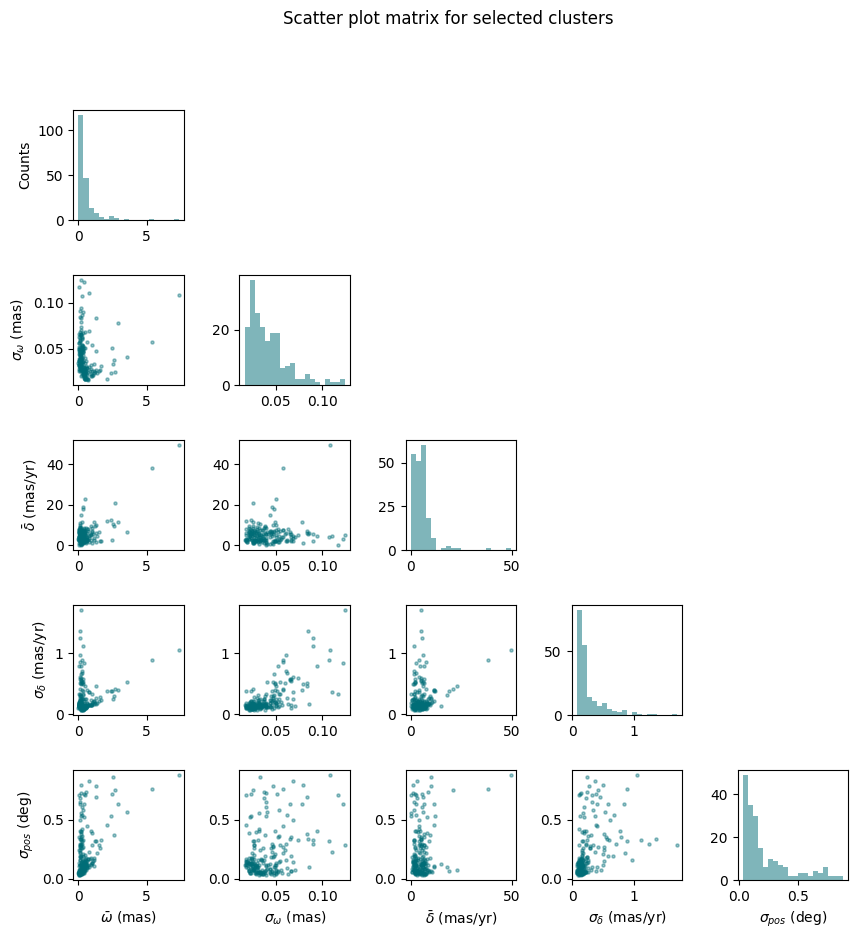

In [8]:
# %matplotlib widget
def multivariate_plot(data, to_plot, labels=None):
    """
    Function that takes in the star data data frame, splits into the requried 10 samples and plots a multivariate plots of them.
    stars:
    - dataframe corresponding to the star data
   labels: list/array of strings
   - list of labels for the plot
    to_plot: 
    - Parameters that needed to be plotted (need to be column names of the star dataframe)
    """
    length = len(to_plot)
    fig, axes = plt.subplots(length,length,figsize=(10,10))
    fig.subplots_adjust(wspace=0.5,hspace=0.5)
    fig.suptitle(f'Scatter plot matrix for selected clusters')
    if labels == None:
        labels = to_plot
        
    for count1 in range(length):
        for count2 in range(length):
            
            if count1 == count2:
                axes[count1, count2].hist(data[to_plot[count1]], alpha=.5, color='#006D77', bins=20)
                
            elif count1 > count2:
                axes[count1,count2].scatter(data[to_plot[count2]], data[to_plot[count1]], s=5, color='#006D77', alpha=0.4)                
            else:
                axes[count1,count2].axis('off')
            if count1 == length-1:
                axes[count1, count2].set_xlabel(labels[count2])
            if count2 == 0:
                if count1 == 0:
                    axes[count1, count2].set_ylabel('Counts') 
                else:
                    axes[count1, count2].set_ylabel(labels[count1])

    plt.show()

to_plot = ['mean_Plx', 'sd_Plx',  'mean_pm', 'sd_pm', 'sd_pos']
labels = [f'$\\bar{{\omega}}$ (mas)', f'$\sigma_{{\omega}}$ (mas)', f'$\\bar{{\delta}}$ (mas/yr)', f'$\sigma_{{\delta}}$ (mas/yr)', f'$\sigma_{{pos}}$ (deg)']
multivariate_plot(clusters_hiprob, to_plot, labels=labels)

<h2>Comments on Task 1</h2>
Looking at the scatter plot matrix, there are no extremely obvious correlations that we can spot. We can also verify that the data does seem to be identically distributed (that is, drawn from one population). We also note that the data is not normally distributed.

<h2>Task 2</h2>
Defining a function that calculates the Pearson's r values and the Spearmen's rho values for both a non-log dataset and the log of the dataset

In [9]:
def calc_r_and_rho(data, params, type='linear'):
    """
    Runs the pearson and spearman tests on the given data and parameters. Can be set to run test on log of the data.
    Parameters
    data: pandas dataframe
    - Data of clusters 
    params: list of str
    - Has to correspond to column names
    type: str (either 'linear' or 'log')
    - set to log to use log of data
    """
    headers = [['Param 1', 'Param 2', 'Pearson\'s r', 'Pearson\'s r pva', 'Spearman\'s rho', 'Spearman\'s rho p val']]
    display_df_res=[]
    
    if type=='linear': 
        for count1 in range(len(params)):
            for count2 in range(len(params)):                
                if count1 > count2:
                    r_cor, r_pval = sts.pearsonr(data[params[count2]], data[params[count1]])                
                    rho_cor, rho_pval = sts.spearmanr(data[params[count2]], data[params[count1]])
                    display_df_res.append([params[count1], params[count2], r_cor, r_pval, rho_cor, rho_pval])
        display_df_res = pd.DataFrame(display_df_res, columns = headers)

    if type=='log':
        for count1 in range(len(params)):
            for count2 in range(len(params)):
                if count1 > count2:
                    r_cor, r_pval = sts.pearsonr(np.log10(data[params[count2]]), np.log10(data[params[count1]]))
                    rho_cor, rho_pval = sts.spearmanr(np.log10(data[params[count2]]), np.log10(data[params[count1]]))
                    display_df_res.append([params[count1], params[count2], r_cor, r_pval, rho_cor, rho_pval])
        display_df_res = pd.DataFrame(display_df_res, columns=headers)

    return display_df_res
    

We can now run the function for our cluster dataset and then look at the results

In [10]:
lin_results = calc_r_and_rho(clusters_hiprob, to_plot, type='linear')
lin_results

,Param 1,Param 2,Pearson's r,Pearson's r pva,Spearman's rho,Spearman's rho p val
0,sd_Plx,mean_Plx,0.047611,5.053547e-01,-0.376186,4.712017e-08
1,mean_pm,mean_Plx,0.668548,5.222066e-27,0.051292,4.729721e-01
2,mean_pm,sd_Plx,0.129134,6.980531e-02,-0.013398,8.513929e-01
3,sd_pm,mean_Plx,0.228468,1.206247e-03,0.025229,7.242273e-01
4,sd_pm,sd_Plx,0.713024,4.760937e-32,0.604036,4.484188e-21
5,sd_pm,mean_pm,0.264974,1.615733e-04,0.153248,3.112366e-02
6,sd_pos,mean_Plx,0.476555,1.275929e-12,0.373636,5.897056e-08
7,sd_pos,sd_Plx,0.341305,8.621712e-07,0.208774,3.160198e-03
8,sd_pos,mean_pm,0.236015,8.156744e-04,-0.005288,9.410603e-01
9,sd_pos,sd_pm,0.403202,3.872148e-09,0.554065,2.508930e-17


In [11]:
log_results = calc_r_and_rho(clusters_hiprob, to_plot, type='log')
log_results

,Param 1,Param 2,Pearson's r,Pearson's r pva,Spearman's rho,Spearman's rho p val
0,sd_Plx,mean_Plx,-0.252036,3.409650e-04,-0.376186,4.712017e-08
1,mean_pm,mean_Plx,0.196391,5.553836e-03,0.051292,4.729721e-01
2,mean_pm,sd_Plx,-0.002964,9.669425e-01,-0.013398,8.513929e-01
3,sd_pm,mean_Plx,0.111445,1.180250e-01,0.025229,7.242273e-01
4,sd_pm,sd_Plx,0.673524,1.576212e-27,0.604036,4.484188e-21
5,sd_pm,mean_pm,0.169528,1.695536e-02,0.153248,3.112366e-02
6,sd_pos,mean_Plx,0.428522,3.012242e-10,0.373636,5.897056e-08
7,sd_pos,sd_Plx,0.264515,1.660300e-04,0.208774,3.160198e-03
8,sd_pos,mean_pm,-0.027338,7.022286e-01,-0.005288,9.410603e-01
9,sd_pos,sd_pm,0.557149,1.535025e-17,0.554065,2.508930e-17


<h2>Comments on obtained results</h2>
Pearson's tests are much more likely to be influence by large outliers. When we convert the values into a log scale, how far away the outliers lie from the data (in an absolute sense) become smaller - this should should result in an increase in the p values for samples that have large outliers. An example of this is the correlation between mean proper motion and mean parallax; the scatter plot shows that this plot has a small number of very large outliers. We can see that when we switch to log values, the p values for the Pearson's r test for the correlation between the mean parallax and mean proper motion increases (from in the order of 1e-27 to the order of 1e-3). Of course, neither of these tests are reliable here since, as we have stated before, it is very heavily influenced by a small number of large outliers. <br><br>

In the case of the Spearman's test, we can see that carrying out the test on log or non-log data makes no difference to the results. This makes sense as the Spearman's test uses rankings and differences in rankings of the data in order to predict correlations and since the rankings will stay the same when we use log values, this makes no difference in the results of the test.

These tests make use of both the central limit theorem and the assumption that the data are independant and identically distributed. From the plots, the data does seem to be individually distributed and it is fair to assume that the measurements are independant. 
Central limit theorem is less of a fair assumption as we only have a sample of 198 clusters and the data seems to have a skewed distribution in some cases.

<h1>Task 3</h1>

Below, we create two functions that calculate the posterior probability distribution and calculate the intervals and mode respectively.
The posterior pdf is calculated using Baye's theorem:
$$
p(d|\omega) = \frac{p(\omega|d) p(d)}{p(\omega)}
$$
The function allows for both the calculation of a uniform prior and a prior of the form 
$$
p(d) \propto d^2 e^{-d/L}
$$
where L is a length scale equal to 1 kpc

<h3>Calculating the standard error on Parallax</h3>
In order to calculate the standard error on the parallaxes, the following formula is used:
$$
s_x = \sqrt{\frac{1}{n-1}\sum_{i=1}^{n} (x_i - \bar{x})^2}
$$
and 
$$
s_{\bar{x}} = \frac{s_x}{\sqrt{n}}
$$
which is then propogated to the distance using:
$$
s_\bar{d} = \bar{d} * \frac{s_\bar{\omega}}{\bar{\omega}}
$$
<i>This method does ignore the errors on the data themselves</i>

In [12]:
def dist_posterior_const_prior(cl_name, star_data, const_prior=True):
    """
    Function that calculates a posterior distribution for the distance using Baye's Theorem.
    cl_name: str
    - Name of cluster to be selected
    star_data: pandas dataframe
    - Data on stars that includes the parallax and error on parallaxes
    """
    # Select stars with the given cluster name
    selected_stars = star_data[star_data['Name'] == cl_name]

    # Get parallax and parallax error values
    plx_vals = selected_stars['Plx'].values + 0.029 # 0.029 is the known correction factor for Gaia
    e_plx_vals = selected_stars['e_Plx'].values

    # Calculate mean of parallax and the standard error
    plx_mean = np.mean(plx_vals)
    e_plx_mean = np.mean(e_plx_vals)
    
    n = len(plx_vals)
    std = np.sqrt((1/(n-1)) * np.sum((plx_vals-plx_mean)**2))
    std_error = std/np.sqrt(n)

    # Define a range of distances to carry out calculations along with the corresponding range of parallax values
    # Ranges of distances defined based on parallax standard errors
    dist_min = 1/(plx_mean + 6*std_error)
    dist_max = 1/(plx_mean - 6*std_error)
    dist_range = dist_range = np.linspace(dist_min,dist_max, 1000)
    parallax_range = 1/dist_range
    
    # Define a constant prior = 1
    if const_prior:
        prior = 1
    else:
        prior = dist_range**2 * np.exp(-dist_range/1)
   
    # Define the numerator of the Bayes Theorem in log space (the products become a sum)
    # The below code is adapted from episode 7 (Baye's Theorem)
    loglikel_prior = np.sum(sps.norm.logpdf(x = plx_vals.reshape(len(plx_vals), 1), scale = e_plx_vals.reshape(len(e_plx_vals),1), loc = parallax_range), axis=0) + np.log(prior)

    # Shift the function up to make it have handle-able values in linspace
    likel_prior = np.exp(loglikel_prior-np.amax(loglikel_prior))
    # Integrate over our distance for the denominator to the Baye's Theorem
    likel_prior_int = spint.simpson(likel_prior,dist_range,axis=0)
    # Calculate the posterior pdf (numerator/denominator)
    posterior_pdf = likel_prior/likel_prior_int

    

    return dist_range, posterior_pdf, plx_mean, std_error



def calc_intervals_mode(dist_range, posterior_pdf):
    # We integrate to obtain the cdf of the posterior
    posterior_cdf = spint.cumulative_trapezoid(posterior_pdf,dist_range,initial=0)

    # We need to invert the cdf so that we can pick out values of distance for given values of probability
    posterior_ppf = spinterp.interp1d(posterior_cdf,dist_range)

    sig_pval = 0.3173
    d_interval = posterior_ppf([sig_pval/2, 1-sig_pval/2])

    mode = dist_range[posterior_pdf == np.max(posterior_pdf)]

    return d_interval, mode

cl_name = np.random.choice(clusters_hiprob['Name'])

# Comment out the below line to use a randomly sample cl_name - the name is set so that the comments match the data
cl_name='BH_140' 

color_const_prior = '#66c2a5'
color_nonconst_prior = '#fc8d62'
color_err_prop = '#8da0cb'

Doing the analysis now for the entire data set. 

The mode fpr constant prior is: 4.641628286900963
The mode for non constant prior is: 4.640440592429576


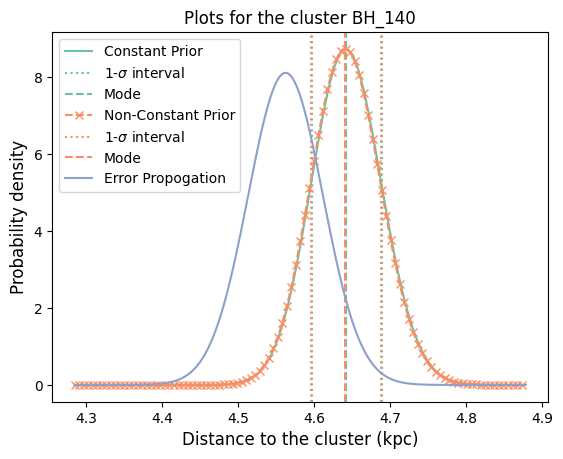

In [13]:
# Calculate posterior pdf for constant prior
dist_range, posterior_pdf, mean_plx, e_plx_mean = dist_posterior_const_prior(cl_name, stars_hiprob, const_prior=True)
plt.plot(dist_range, posterior_pdf, label='Constant Prior', color=color_const_prior)

# Calculate 1-sigma intervals, and mode. Plot corresponding vertical lines
intervals, mode = calc_intervals_mode(dist_range, posterior_pdf)
plt.axvline(intervals[0], linestyle=':', label=r'1-$\sigma $ interval', color=color_const_prior)
plt.axvline(intervals[1], linestyle=':', color=color_const_prior)
plt.axvline(mode[0], linestyle='--', label='Mode', color=color_const_prior)
print('The mode fpr constant prior is:', mode[0])

# Calculate posterior pdf for non-constant prior
dist_range, posterior_pdf, mean_plx, e_plx_mean = dist_posterior_const_prior(cl_name, stars_hiprob, const_prior=False)
plt.plot(dist_range, posterior_pdf, '--', label='Non-Constant Prior', color=color_nonconst_prior, marker='x', markevery=10)

# Calculate 1-sigma intervals, and mode. Plot corresponding vertical lines
intervals, mode = calc_intervals_mode(dist_range, posterior_pdf)
plt.axvline(intervals[0], linestyle=':', label=r'1-$\sigma $ interval', color=color_nonconst_prior)
plt.axvline(intervals[1], linestyle=':', color=color_nonconst_prior)
plt.axvline(mode[0], linestyle='--', label='Mode', color=color_nonconst_prior) 
print('The mode for non constant prior is:', mode[0])

# Plot the distribution using error propogation
e_dist = e_plx_mean
mean_dist = 1/mean_plx
std_d = mean_dist * (e_dist/mean_plx)
pdf_something = sts.norm.pdf(x=dist_range, loc=1/mean_plx, scale=std_d)
plt.plot(dist_range, pdf_something, label='Error Propogation', color=color_err_prop)


# Plot Styling
plt.xlabel(r'Distance to the cluster (kpc)',fontsize=12)
plt.ylabel(r'Probability density',fontsize=12)

# Zoom in by setting limits so that the curve is more visible
# plt.xlim(4, 5.5)
# plt.ylim(0,10)

plt.legend()
plt.title(f'Plots for the cluster {cl_name}')
# plt.savefig('temp.pdf')
plt.show()

Now we sample just 10 stars from a given cluster and carry out the same analysis

The mode for non constant prior is: 3.4918973008324814
The mode for non constant prior is: 3.4558677696202587


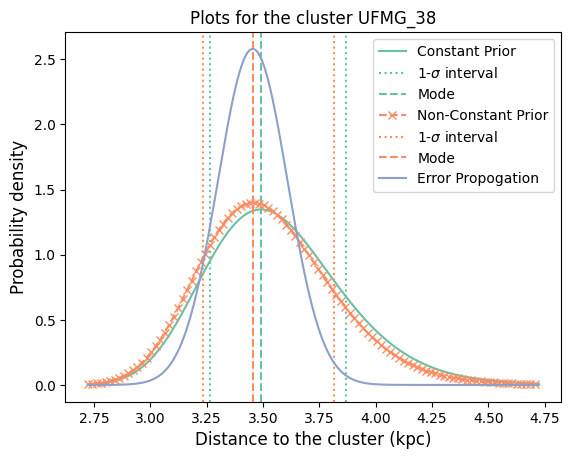

In [37]:
selected_stars = stars_hiprob[stars_hiprob['Name'] == cl_name]
new_stars = selected_stars.sample(10)

# Calculate posterior pdf for constant prior
dist_range, posterior_pdf, mean_plx, e_plx_mean = dist_posterior_const_prior(cl_name, new_stars, const_prior=True)
plt.plot(dist_range, posterior_pdf, label='Constant Prior', color=color_const_prior)

# Calculate 1-sigma intervals, and mode. Plot corresponding vertical lines
intervals, mode = calc_intervals_mode(dist_range, posterior_pdf)
plt.axvline(intervals[0], linestyle=':', label=r'1-$\sigma $ interval', color=color_const_prior)
plt.axvline(intervals[1], linestyle=':', color=color_const_prior)
plt.axvline(mode[0], linestyle='--', label='Mode', color=color_const_prior) 
print('The mode for non constant prior is:', mode[0])

# Calculate posterior pdf for non-constant prior
dist_range, posterior_pdf, mean_plx, e_plx_mean = dist_posterior_const_prior(cl_name, new_stars, const_prior=False)
plt.plot(dist_range, posterior_pdf, '--', label='Non-Constant Prior', color=color_nonconst_prior, marker='x', markevery=10)

# Calculate 1-sigma intervals, and mode. Plot corresponding vertical lines
intervals, mode = calc_intervals_mode(dist_range, posterior_pdf)
plt.axvline(intervals[0], linestyle=':', label=r'1-$\sigma $ interval', color=color_nonconst_prior)
plt.axvline(intervals[1], linestyle=':', color=color_nonconst_prior)
plt.axvline(mode[0], linestyle='--', label='Mode', color=color_nonconst_prior) 
print('The mode for non constant prior is:', mode[0])


# Plot the distribution using error propogation
e_dist = e_plx_mean
mean_dist = 1/mean_plx
std_d = mean_dist * (e_dist/mean_plx)
pdf_something = sts.norm.pdf(x=dist_range, loc=1/mean_plx, scale=std_d)
plt.plot(dist_range, pdf_something, label='Error Propogation', color=color_err_prop)


# Plot Styling
plt.xlabel(r'Distance to the cluster (kpc)',fontsize=12)
plt.ylabel(r'Probability density',fontsize=12)

# Zoom in by setting limits so that the curve is more visible
# plt.xlim(4, 5.5)
# plt.ylim(0,10)

plt.legend()
plt.title(f'Plots for the cluster {cl_name}')
# plt.savefig('temp.pdf')
plt.show()

<h2>Comments on Task 3</h2>
As we can see, the curves dont quite agree as well here. We also get a very different value for the mode. This is because we have a much smaller sample set which leads to the posterior pdf not being able to converge onto the population mean. There is also the question of the smaller sample set not being completely representing the complete sample set - this is noticed by the plots changing drastically for different samplings (that is, if we keep re-running the cell, we get widely different plots)

<h1>Task 4</h1>

Here, we normalize the clusters' data using the distance to them. In order to this, we scale each parameter by the distance to the cluster (since to get them all to the same distance, we need to multiply the parallaxes by the factor due to their inverse relation to distance)

In [15]:
dist_arr = []
for cl_name in clusters_hiprob['Name']:
    dist_range, posterior_pdf, mean_plx, e_plx_mean = dist_posterior_const_prior(cl_name, stars_hiprob, const_prior=False)
    dist_cl = dist_range[posterior_pdf == np.max(posterior_pdf)]
    dist_arr.append(dist_cl[0])

In [16]:
factor = np.array(dist_arr)
scaled_clusters = clusters_hiprob[['sd_Plx', 'mean_Plx','sd_pm', 'mean_pm','sd_pos']].mul(factor,axis=0)
scaled_clusters.insert(loc=0, column='Name', value=clusters_hiprob['Name'])
scaled_clusters

,Name,sd_Plx,mean_Plx,sd_pm,mean_pm,sd_pos
135,BH_131,0.296680,0.806563,0.991241,41.964965,1.423134
137,BH_140,0.201796,0.882589,0.601611,69.128859,0.591302
161,BH_66,0.295269,0.808325,1.507086,35.925112,1.187564
217,Berkeley_36,0.267847,0.883823,0.404133,8.001857,0.257156
219,Berkeley_39,0.152369,0.903265,0.273180,9.437061,0.181619
...,...,...,...,...,...,...
6763,UBC_461,0.095237,0.895479,0.329272,12.278735,1.256562
6805,UBC_517,0.051944,0.929014,0.291980,13.020202,1.641681
6872,UBC_600,0.190493,0.824438,0.646794,5.739079,3.475141
6926,UFMG_2,0.066721,0.939497,0.255120,13.402831,0.182358


Now we plot a multivariate plot of the resulting data

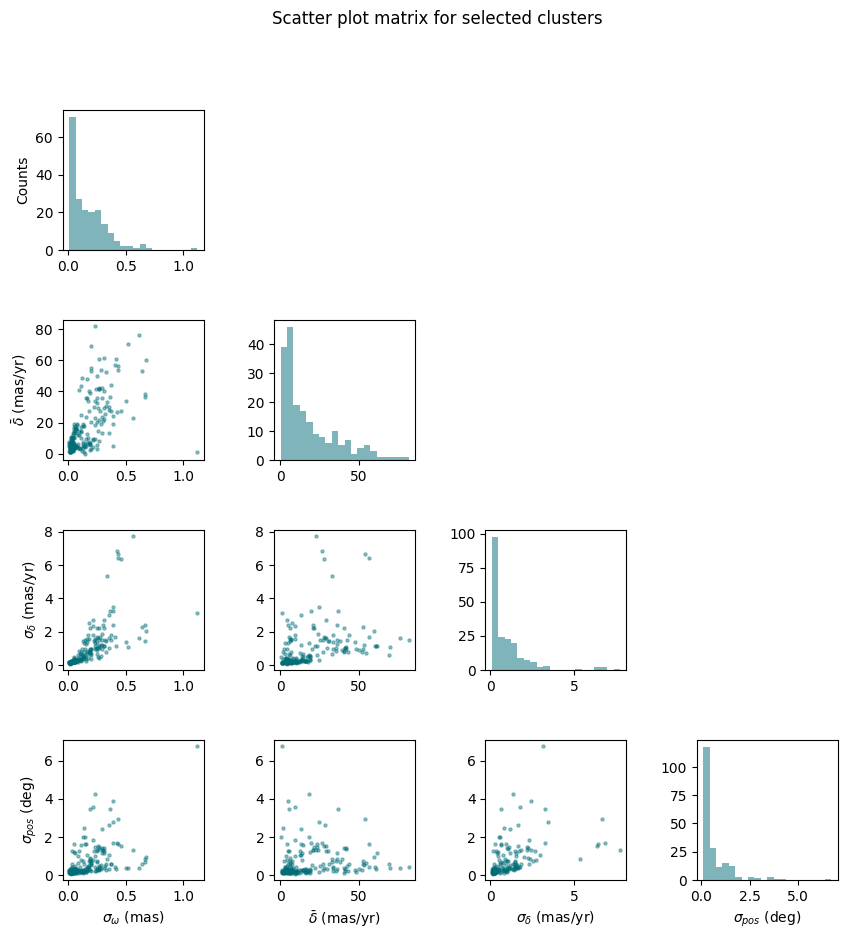

In [17]:
to_plot = ['sd_Plx',  'mean_pm', 'sd_pm', 'sd_pos']
labels = [f'$\sigma_{{\omega}}$ (mas)', f'$\\bar{{\delta}}$ (mas/yr)', f'$\sigma_{{\delta}}$ (mas/yr)', f'$\sigma_{{pos}}$ (deg)']
multivariate_plot(scaled_clusters, to_plot=to_plot, labels=labels)

And then we run the Pearson and Spearman tests on the logarithms of the data

In [18]:
log_results_scaled_cl = calc_r_and_rho(scaled_clusters, to_plot, type='log')
log_results_scaled_cl

,Param 1,Param 2,Pearson's r,Pearson's r pva,Spearman's rho,Spearman's rho p val
0,mean_pm,sd_Plx,0.601073,7.805014e-21,0.660144,3.750265e-26
1,sd_pm,sd_Plx,0.888215,3.987732e-68,0.919453,2.166342e-81
2,sd_pm,mean_pm,0.563981,5.076839e-18,0.593797,2.971096e-20
3,sd_pos,sd_Plx,0.628042,4.032901e-23,0.677019,6.701191e-28
4,sd_pos,mean_pm,0.255555,2.793428e-04,0.357979,2.243465e-07
5,sd_pos,sd_pm,0.712126,6.151539e-32,0.735555,5.503052e-35


We are getting some extremely high correlation values, let us plot the multivariate plot of the log of our data to see if that makes sense

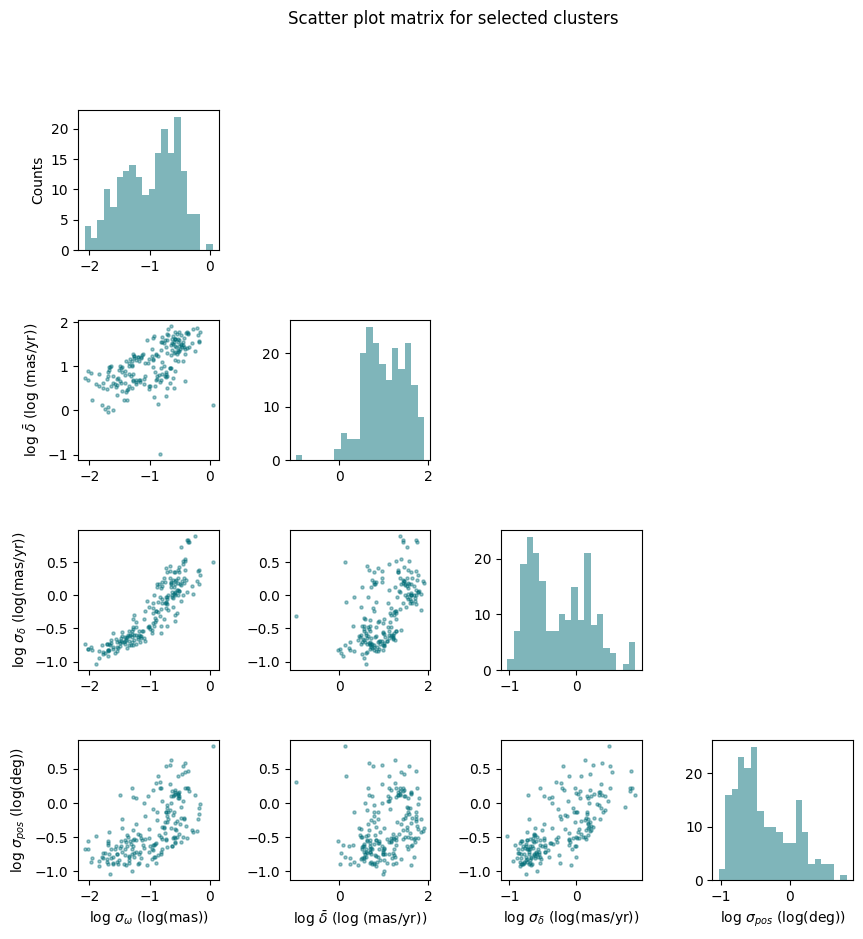

In [19]:
scaled_clusters_log=np.log10(scaled_clusters[['sd_Plx', 'mean_Plx','sd_pm', 'mean_pm','sd_pos']])
labels = [f'log $\sigma_{{\omega}}$ (log(mas))', f'log $\\bar{{\delta}}$ (log (mas/yr))', f'log $\sigma_{{\delta}}$ (log(mas/yr))', f'log $\sigma_{{pos}}$ (log(deg))']
multivariate_plot(scaled_clusters_log, to_plot=to_plot, labels=labels)

<h2>Comments on Task 4</h2>
According to both the Pearson and Spearman tests, all parameters share a correlation with each other to a 3-$\sigma$ confidence interval. This is quite different from the results of the tests performed on the un-scaled data where only a select few parameters showed correlation.<br>
For the Pearson's and Spearman's tests to be valid, the data must independantly and identically distributed. Looking at the scatter plot matrix for the log of the data, the individually distributed assumption does seem to be fair. We can safely assume independant distributions as well since we can assume the measurements are not dependant on each other. <br>
We also assume that the tests' t parameters follows a t-dsitribution, which follows from the central limit theorem. In this case, looking at the histograms in the scatter plot matrix, I am not certain that this assumption holds since they do not look normal and we only have a relatively small sample size (198). <br>
Although the results of the Pearson and Spearman tests rely on the above mentioned dubious assumption, it is quite apparent from just looking at the plots that a lot of the parameters do share some correlation in the log plane (log $\sigma_\omega$ and log $\sigma_\delta$ for example).